# Imports

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

from helper_functions import print_structure

# Read data and pre-processing

In [2]:
shipsnet_path = "dataset/shipsnet.json"

with open(shipsnet_path) as f:
    data = json.load(f)  

In [3]:
print_structure(data)

data: list
  list[4000]: list
    list[19200]: int
labels: list
  list[4000]: int
locations: list
  list[4000]: list
    list[2]: float
scene_ids: list
  list[4000]: str


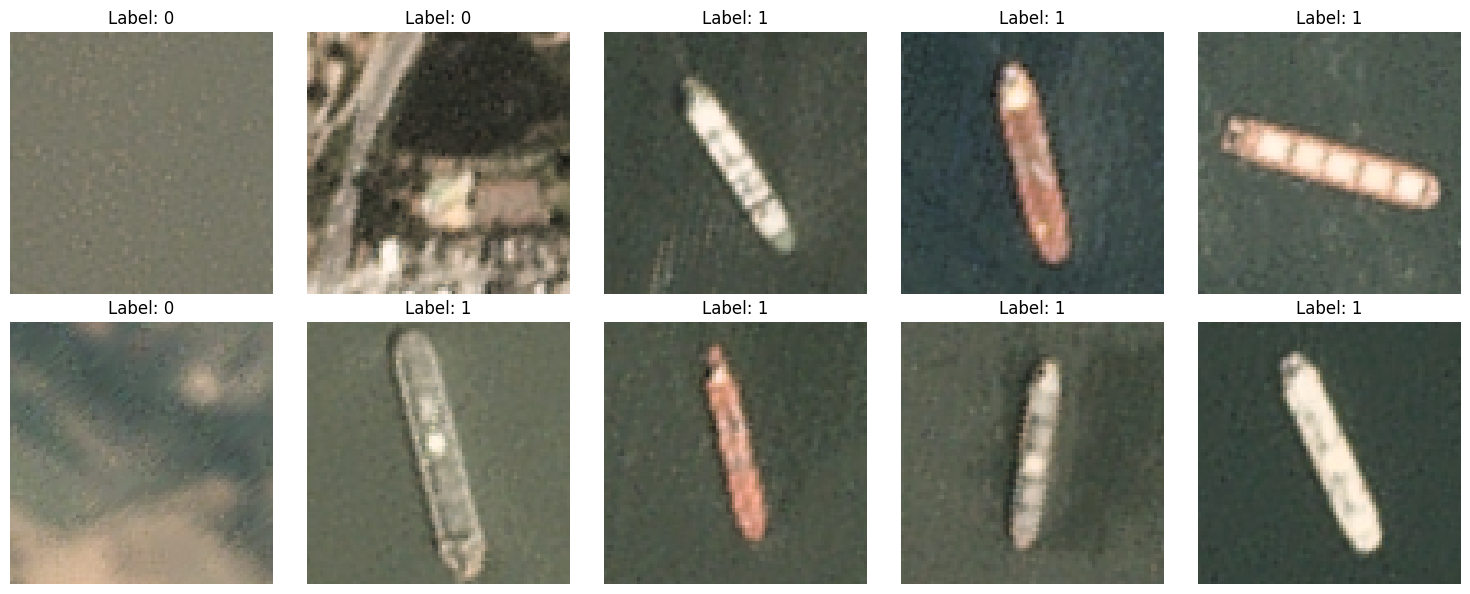

In [4]:
X_data = np.array(data["data"][:2000])
y_data = np.array(data["labels"][:2000])

X_data_transformed = X_data.reshape(-1, 3, 80, 80).transpose(0, 2, 3, 1)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
indices = np.random.randint(0,2000,size = 10)

for ax, idx in zip(axes.flat, indices):
    ax.imshow(X_data_transformed[idx].astype(np.uint8))
    ax.set_title(f"Label: {y_data[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Train the model

In [ ]:
from CNN import CNN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

X_tensor = torch.tensor(X_data_transformed, dtype=torch.float32).permute(0, 3, 1, 2)
y_tensor = torch.tensor(y_data, dtype=torch.long)

# Split indices
num_samples = X_tensor.size(0)
train_size = int(0.8 * num_samples)
test_size = num_samples - train_size

indices = torch.randperm(num_samples)
train_idx, test_idx = indices[:train_size], indices[train_size:]

# Create splits
X_train, y_train = X_tensor[train_idx], y_tensor[train_idx]
X_test, y_test = X_tensor[test_idx], y_tensor[test_idx]

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def rwg(x):
    return torch.maximum(torch.zeros_like(x), x * torch.exp(-x ** 2))

model = CNN(rwg, dropout_rate=0.5).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

best_loss = float('inf')

for epoch in range(1000):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = 100 * total_correct / total_samples

    print(f"Epoch {epoch+1} completed, Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    if avg_loss > best_loss * 1.2:
        print("Stopping early due to loss increase")
        break

    best_loss = avg_loss

# Test evaluation
model.eval()
test_correct = 0
test_samples = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        test_correct += (preds == labels).sum().item()
        test_samples += labels.size(0)

test_accuracy = 100 * test_correct / test_samples
print(f"Test Accuracy: {test_accuracy:.2f}%")

cpu
Epoch 1 completed, Avg Loss: 0.6928, Accuracy: 50.06%
Epoch 2 completed, Avg Loss: 0.6613, Accuracy: 73.88%
Epoch 3 completed, Avg Loss: 0.4899, Accuracy: 87.00%
Epoch 4 completed, Avg Loss: 0.3619, Accuracy: 89.44%
Epoch 5 completed, Avg Loss: 0.2754, Accuracy: 91.50%
Epoch 6 completed, Avg Loss: 0.2498, Accuracy: 92.38%
Epoch 7 completed, Avg Loss: 0.2587, Accuracy: 90.44%
Epoch 8 completed, Avg Loss: 0.2459, Accuracy: 91.19%


# Initialise Framework

In [ ]:
from seu_injection import ExhaustiveSEUInjector, StochasticSEUInjector
from seu_injection.metrics import classification_accuracy

injector = StochasticSEUInjector(trained_model=model,
                                 criterion=classification_accuracy,
                                 data_loader=test_loader)

Testing a forward pass on cpu...
Baseline Criterion Score: 0.915


# Run Framework

In [ ]:
layers = [name for name, _ in model.named_parameters()]
print(layers)

['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'fc1.weight', 'fc1.bias']


In [ ]:

injector.run_injector(bit_i=0, layer_name=layers[0], p = 0.01)